Environment creation

In [ ]:
!pip install yfinance 
!pip install yahoo_fin 
!pip install gym-anytrading

In [ ]:
import yfinance as yf
import yahoo_fin as y_fin
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
import csv
from gym import spaces
from datetime import datetime
import matplotlib.pyplot as plt
from datetime import datetime
from calendar import isleap

In [ ]:
Stocks=["AMZN","MSFT","GOOG"]

apple=yf.Ticker("AAPL")
amazon=yf.Ticker("AMZN")
msft=yf.Ticker("MSFT")

In [ ]:
appledf = apple.history(start="2010-06-02", end="2022-05-01")[["Open", "High", "Low", "Close", "Volume"]].reset_index(drop=True)
amazondf = amazon.history(start="2010-06-02", end="2022-05-01")[["Open", "High", "Low", "Close", "Volume"]].reset_index(drop=True)
msftdf = msft.history(start="2010-06-02", end="2022-05-01")[["Open", "High", "Low", "Close", "Volume"]].reset_index(drop=True)
print(appledf.shape)
print(appledf.head)

(3000, 5)
<bound method NDFrame.head of             Open        High         Low       Close      Volume
0       8.089956    8.097907    7.961209    8.071914   688548000
1       8.109527    8.120843    7.963655    8.046531   650106800
2       7.896378    8.009223    7.786898    7.827571   758304400
3       7.898821    7.925120    7.662122    7.674049   886942000
4       7.744392    7.761518    7.512281    7.624820  1000770400
...          ...         ...         ...         ...         ...
2995  161.119995  163.169998  158.460007  162.880005    96046400
2996  162.250000  162.339996  156.720001  156.800003    95623200
2997  155.910004  159.789993  155.380005  156.570007    88063200
2998  159.250000  164.520004  158.929993  163.639999   130216800
2999  161.839996  166.199997  157.250000  157.649994   131587100

[3000 rows x 5 columns]>


In [ ]:
import gym
import gym_anytrading
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import matplotlib.pyplot as plt

#env = gym.make('forex-v0', frame_bound=(50, 100), window_size=10 )
env = gym.make('stocks-v0', df = appledf, frame_bound=(10,100), window_size=10)
env1 = gym.make('stocks-v0', df = amazondf, frame_bound=(10, 100), window_size=10)
env2 = gym.make('stocks-v0', df = msftdf, frame_bound=(10, 100), window_size=10)


In [ ]:
env.action_space.n

2

In [ ]:
print(env.action_space)
print(env.observation_space)

Discrete(2)
Box(-inf, inf, (3000, 2), float32)


In [ ]:
import pandas
# Importing libraries
import gym
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import torch as T
from gym import spaces
import torch.autograd as autograd 


In [ ]:
import numpy as np

class OUActionNoise:
    def __init__(self, action_space, mu = 0, sigma=0.4, theta=.01, scale=0.1):
        self.theta = theta
        self.mu = mu*np.ones(action_space)
        self.sigma = sigma
        self.scale = scale
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) + self.sigma * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x * self.scale

    def reset(self):
        self.x_prev = np.zeros_like(self.mu)

In [ ]:
import time
from collections import deque

class ReplayBuffer():
    def __init__(self, env , action_available,  size=1000, batch_size=100):
        self.size=size
        self.count=0
        self.env=env
        self.action_available=action_available
        self.batch_size=batch_size
        self.buffer = deque(maxlen=self.size)

    def reset(self):
        self.count=0
        self.buffer = deque(maxlen=self.size)

    def add(self, prev_state, action, reward, next_state, done):
        if self.count<self.size:
            self.buffer.append((prev_state, action, reward, next_state, done))
        else:
            idx = self.count%self.size
            self.buffer[idx] = (prev_state, action, reward, next_state, done)
            self.count+=1
            self.count%=self.size
        
    def getSampledData(self):
        mlength = min(self.size, self.count)
        random_index_array = np.random.choice(self.buffer,self.batch_size, replace=True)
        prev_state, action, reward, next_state, done = zip(*random_index_array)
        prev_state = np.array(prev_state, dtype=np.float64)
        action = np.array(action, dtype=np.float64)
        reward = np.array(reward, dtype=np.float64)
        next_state = np.array(next_state, dtype=np.float64)
        done = np.array(done, dtype=np.float64)
        return prev_state, action, reward, next_state, done

In [ ]:
class Critic(nn.Module):
    def __init__(self, state=4, action=2, f1=128,f2=128, lr=0.0005):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state, f1) 
        self.fc1.weight.data.normal_(-0.03, 0.03)
        self.fc2 = nn.Linear(f1, f2) 
        self.fc2.weight.data.normal_(-0.03, 0.03)
        self.actionNNL = nn.Linear(action, f2)
        self.fc3 = nn.Linear(f2, 1) # 2 for the number of CARTOPLOE(ACTION) 1 for CRITIC
        self.fc3.weight.data.normal_(-0.03, 0.03)
        self.loss = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(),lr=lr)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, x, action):
        x = T.Tensor(x).to(self.device)
        action = T.tensor(action).to(self.device)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x2 = self.actionNNL(action)
        x = x.add(x2)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [ ]:
class Actor(nn.Module):
    def __init__(self, state=4, action=2, f1=128,f2=128, lr=0.00001):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state, f1) 
        self.fc1.weight.data.normal_(-0.03, 0.03)
        self.fc2 = nn.Linear(f1, f2) 
        self.fc2.weight.data.normal_(-0.03, 0.03)
        self.fc3 = nn.Linear(f2, action) # 2 for the number of CARTOPLOE(ACTION) 1 for CRITIC
        self.fc3.weight.data.normal_(-0.03, 0.03)
        self.loss = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(),lr=lr)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, x):
        x = T.Tensor(x).to(self.device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class Agent():
    def __init__(self,env,tau=0.005, fc1=128,fc2=128):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.gamma = 0.99
        self.epsilon=0.99
        self.beta = 0.0005
        self.alpha = 0.00001
        self.tau=tau
        self.actor = Actor(state=self.observation_space.shape[0]*self.observation_space.shape[1],action=self.action_space.n,f1=fc1,f2=fc2,lr=self.alpha)
        self.actor_target = Actor(state=self.observation_space.shape[0]*self.observation_space.shape[1],action=self.action_space.n,f1=fc1,f2=fc2,lr=self.alpha)

        self.critic = Critic(state=self.observation_space.shape[0]*self.observation_space.shape[1], action=self.action_space.n,f1=fc1,f2=fc2,lr=self.beta)
        self.critic_target = Critic(state=self.observation_space.shape[0]*self.observation_space.shape[1], action=self.action_space.n,f1=fc1,f2=fc2,lr=self.beta)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.alpha)
        self.critic_optimizer = optim.Adam(self.critic.parameters(),lr=self.beta)
        self.log_p = None
        self.replay_buffer= ReplayBuffer(self.env, self.action_space.n, size=10000, batch_size=100)
        self.noise = OUActionNoise(action_space=self.action_space.n)
    
    def stepWithNoise(self, agent_pos):
        agent_pos = T.FloatTensor(agent_pos).to(self.device)
        d = self.actor.forward(agent_pos)
        d = d + T.tensor(self.noise(),dtype=T.float).to(self.actor.device)
        #action = Categorical(F.softmax(d,dim=-1)) 
        #action_p = action.sample()
        #value = self.critic(agent_pos)
        #self.log_p = action.log_prob(action_p).unsqueeze(0)
        return np.random.randint(0,3)

    def stepWithoutNoise(self, agent_pos):
        agent_pos = T.FloatTensor(agent_pos).to(self.device)
        d = self.actor.forward(agent_pos)
        #d = d + T.tensor(self.noise(),dtype=T.float).to(self.actor.device)
        #action = Categorical(F.softmax(d,dim=-1)) 
        #action_p = action.sample()
        #value = self.critic(agent_pos)
        #self.log_p = action.log_prob(action_p).unsqueeze(0)
        d = d.cpu().detach().numpy()
        m = np.max(d)
        idx=-1
        for i in range(len(d)):
            if m==d[i]:
                idx=i

        return idx
    
    def learnPolicy(self):
        if self.replay_buffer.count < self.replay_buffer.batch_size:
            return
            #prev_state, action, reward, next_state, done
        prev_state, action, reward, next_state, done = self.replay_buffer.getSampledData()
        next_state = T.FloatTensor(next_state).to(self.device)
        prev_state = T.FloatTensor(prev_state).to(self.device)
        reward = T.FloatTensor(reward).to(self.device)
        done = T.FloatTensor(done).to(self.device)
        action = T.FloatTensor(action).to(self.device)

        #V(t1)
        val_t1 = self.critic_target.forward(next_state, self.actor_target.forward(next_state))
        #V(t)
        val_t = self.critic.forward(prev_state, action)
        # detla = reward + gamma * V(t+1) - V(t)
        delta = reward+self.gamma*val_t1*done - val_t
        mu = self.actor.forward(prev_state)

        self.critic.optimizer.zero_grad()
        self.actor.optimizer.zero_grad()
        F.mse_loss(delta, val_t).backward()
        T.mean(-self.critic.forward(prev_state, mu)).backward()
        self.critic.optimizer.step()
        self.actor.optimizer.step()
        #soft update
        for c,tc in zip(self.critic.parameters(), self.critic_target.parameters()):
            tc.data.copy_(self.tau*c+(1-self.tau)*tc)
        for a,ta in zip(self.actor.parameters(), self.actor_target.parameters()):
            ta.data.copy_(self.tau*a+(1-self.tau)*ta)


episode:  0


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode:  200
episode:  400
episode:  600
episode:  800
episode:  1000
episode:  1200
episode:  1400
episode:  1600
episode:  1800
episode:  2000
episode:  2200
episode:  2400
episode:  2600
episode:  2800
episode:  3000
episode:  3200
episode:  3400
episode:  3600
episode:  3800
episode:  4000
episode:  4200
episode:  4400
episode:  4600
episode:  4800
episode:  5000
episode:  5200
episode:  5400
episode:  5600
episode:  5800
episode:  6000
episode:  6200
episode:  6400
episode:  6600
episode:  6800
episode:  7000
episode:  7200
episode:  7400
episode:  7600
episode:  7800
episode:  8000
episode:  8200
episode:  8400
episode:  8600
episode:  8800
episode:  9000
episode:  9200
episode:  9400
episode:  9600
episode:  9800


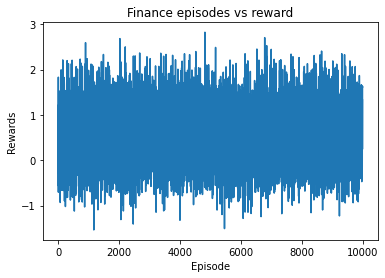

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

episode = 10000
avg_r100= []
avg_r10 = []
reward_per_episode = []
agent = Agent(env, fc1=64, fc2=64)

for i in range(episode):
    prev_state = env.reset()
    done = False
    cumulative_reward = 0
    while not done:
        action = agent.stepWithNoise(prev_state.flatten())
        obs, reward, done, _ = env.step(action)# prev_state, action, reward, next_state, done
        agent.replay_buffer.add(prev_state, action, reward, obs, int(done))
        prev_state=obs
        cumulative_reward += reward
        agent.learnPolicy()
    if i%200==0:
      print("episode: ", i)
    avrRew100 = np.mean(reward_per_episode[-100:])
    avrRew10 = np.mean(reward_per_episode[-10:])
    avg_r100.append(avrRew100)
    avg_r10.append(avrRew10)

    reward_per_episode.append(cumulative_reward)

plt.title("Finance episodes vs reward")
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.plot(reward_per_episode)
plt.show()

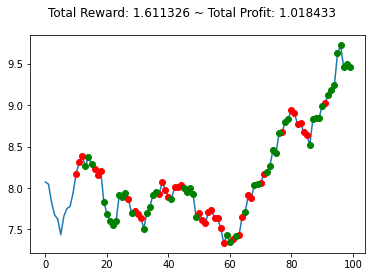

In [ ]:
env.render_all()

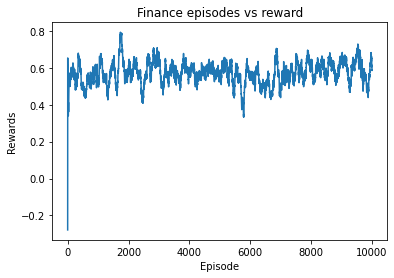

In [ ]:
plt.title("Finance episodes vs reward")
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.plot(avg_r100)
plt.show()

In [ ]:
print(reward_per_episode)

[]


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

episode = 10
avg_r100= []
avg_r10 = []
reward_per_episode = []

for i in range(episode):
    prev_state = env.reset()
    done = False
    cumulative_reward = 0
    while not done:
        print(prev_state)
        action = agent.stepWithoutNoise(prev_state.flatten())
        obs, reward, done, _ = env.step(action)# prev_state, action, reward, next_state, done
        agent.replay_buffer.add(prev_state, action, reward, obs, int(done))
        prev_state=obs
        cumulative_reward += reward
        #agent.learnPolicy()
    if i%200==0:
      print("episode: ", i)
    avrRew100 = np.mean(reward_per_episode[-100:])
    avrRew10 = np.mean(reward_per_episode[-10:])
    avg_r100.append(avrRew100)
    avg_r10.append(avrRew10)
    env.render()

    reward_per_episode.append(cumulative_reward)


##TD 3


In [ ]:
import torch

In [ ]:
env2 = gym.make('stocks-v0', df = amazondf, frame_bound=(10, 200), window_size=10)

### New Critic

In [ ]:
class CriticTD3(nn.Module):
    def __init__(self, state=4, action=2, f1=128,f2=128, lr=0.0005):
        super(CriticTD3, self).__init__()
        self.fc1 = nn.Linear(state+action, f1) 
        self.fc1.weight.data.normal_(-0.03, 0.03)
        self.fc2 = nn.Linear(f1, f2) 
        self.fc2.weight.data.normal_(-0.03, 0.03)
        self.fc3 = nn.Linear(f2, 1) # 2 for the number of CARTOPLOE(ACTION) 1 for CRITIC
        self.fc3.weight.data.normal_(-0.03, 0.03)

        self.fc4 = nn.Linear(state+action, f1) 
        self.fc4.weight.data.normal_(-0.03, 0.03)
        self.fc5 = nn.Linear(f1, f2) 
        self.fc5.weight.data.normal_(-0.03, 0.03)
        self.fc6 = nn.Linear(f2, 1) # 2 for the number of CARTOPLOE(ACTION) 1 for CRITIC
        self.fc6.weight.data.normal_(-0.03, 0.03)

        self.loss = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(),lr=lr)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, x, action):
        x = T.Tensor(x).to(self.device)
        action = T.tensor(action).to(self.device)
        state_action = T.cat([x, action], 1)
        x = F.relu(self.fc1(state_action))
        x = self.fc2(x)
        q1 = self.fc3(x)

        y = F.relu(self.fc1(state_action))
        y = self.fc2(y)
        q2 = self.fc3(y)

        return q1,q2
    def valueForActor(self, x, action):
        x = T.Tensor(x).to(self.device)
        action = T.tensor(action).to(self.device)
        state_action = T.cat([x, action], 1)
        x = F.relu(self.fc1(state_action))
        x = self.fc2(x)
        q1 = self.fc3(x)
        return q1

Agent TD3

In [ ]:
class AgentTD3():
    def __init__(self,env,tau=0.005, fc1=128,fc2=128, freq=10):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.gamma = 0.99
        self.epsilon=0.99
        self.beta = 0.0005
        self.alpha = 0.00001
        self.tau=tau
        self.actor = Actor(state=self.observation_space.shape[0]*self.observation_space.shape[1],action=self.action_space.n,f1=fc1,f2=fc2,lr=self.alpha)
        self.actor_target = Actor(state=self.observation_space.shape[0]*self.observation_space.shape[1],action=self.action_space.n,f1=fc1,f2=fc2,lr=self.alpha)

        self.critic = CriticTD3(state=self.observation_space.shape[0]*self.observation_space.shape[1], action=self.action_space.n,f1=fc1,f2=fc2,lr=self.beta)
        self.critic_target = CriticTD3(state=self.observation_space.shape[0]*self.observation_space.shape[1], action=self.action_space.n,f1=fc1,f2=fc2,lr=self.beta)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.alpha)
        self.critic_optimizer = optim.Adam(self.critic.parameters(),lr=self.beta)
        self.log_p = None
        self.replay_buffer= ReplayBuffer(self.env, self.action_space.n, size=10000, batch_size=100)
        self.noise = OUActionNoise(action_space=self.action_space.n)
        self.count=0
        self.freq = freq
    
    def stepWithNoise(self, agent_pos):
        agent_pos = T.FloatTensor(agent_pos).to(self.device)
        d = self.actor.forward(agent_pos)
        d = d + T.tensor(self.noise(),dtype=T.float).to(self.actor.device)
        d = d.cpu().detach().numpy()
        m = np.max(d)
        idx=-1
        for i in range(len(d)):
            if m==d[i]:
                idx=i

        return idx

    def stepWithoutNoise(self, agent_pos):
        agent_pos = T.FloatTensor(agent_pos).to(self.device)
        d = self.actor.forward(agent_pos)
        #d = d + T.tensor(self.noise(),dtype=T.float).to(self.actor.device)
        #action = Categorical(F.softmax(d,dim=-1)) 
        #action_p = action.sample()
        #value = self.critic(agent_pos)
        #self.log_p = action.log_prob(action_p).unsqueeze(0)
        d = d.cpu().detach().numpy()
        m = np.max(d)
        idx=-1
        for i in range(len(d)):
            if m==d[i]:
                idx=i

        return idx
    
    def learnPolicy(self):
        self.count+=1
        if self.replay_buffer.count < self.replay_buffer.batch_size:
            return
            #prev_state, action, reward, next_state, done
        prev_state, action, reward, next_state, done = self.replay_buffer.getSampledData()
        next_state = T.FloatTensor(next_state).to(self.device)
        prev_state = T.FloatTensor(prev_state).to(self.device)
        reward = T.FloatTensor(reward).to(self.device)
        done = T.FloatTensor(done).to(self.device)
        action = T.FloatTensor(action).to(self.device)

        next_action = self.actor_target.forward(next_state)+self.noise

        tq1,tq2 = self.critic_target.forward(next_state, next_action)
        tqVal_t1 = reward +self.gamma*T.min(tq1,tq2)*done

        q1,q2 = self.critic.forward(prev_state, action)

        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(q1, tqVal_t1) + F.mse_loss(q2, tqVal_t1)
        critic_loss.backward()
        self.critic.optimizer.step()
        #soft update
        #delayed update:
        if self.count%self.freq==0:
            actor_loss = self.critic.valueForActor(prev_state, self.actor.forward(prev_state))
            for c,tc in zip(self.critic.parameters(), self.critic_target.parameters()):
                tc.data.copy_(self.tau*c+(1-self.tau)*tc)
            for a,ta in zip(self.actor.parameters(), self.actor_target.parameters()):
                ta.data.copy_(self.tau*a+(1-self.tau)*ta)


episode:  0


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode:  200
episode:  400
episode:  600
episode:  800
episode:  1000
episode:  1200
episode:  1400
episode:  1600
episode:  1800
episode:  2000
episode:  2200
episode:  2400
episode:  2600
episode:  2800
episode:  3000
episode:  3200
episode:  3400
episode:  3600
episode:  3800
episode:  4000
episode:  4200
episode:  4400
episode:  4600
episode:  4800
episode:  5000
episode:  5200
episode:  5400
episode:  5600
episode:  5800
episode:  6000
episode:  6200
episode:  6400
episode:  6600
episode:  6800
episode:  7000
episode:  7200
episode:  7400
episode:  7600
episode:  7800
episode:  8000
episode:  8200
episode:  8400
episode:  8600
episode:  8800
episode:  9000
episode:  9200
episode:  9400
episode:  9600
episode:  9800


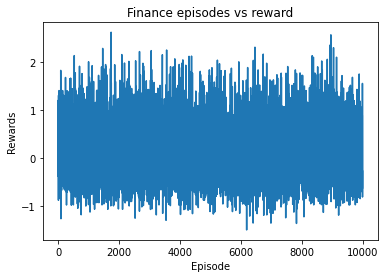

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

episode = 10000
avg_r100= []
avg_r10 = []
reward_per_episode = []
agent = AgentTD3(env2, fc1=64, fc2=64)

for i in range(episode):
    prev_state = env2.reset()
    done = False
    cumulative_reward = 0
    while not done:
        action = agent.stepWithNoise(prev_state.flatten())
        obs, reward, done, _ = env2.step(action)# prev_state, action, reward, next_state, done
        agent.replay_buffer.add(prev_state, action, reward, obs, int(done))
        prev_state=obs
        cumulative_reward += reward
        agent.learnPolicy()
    if i%200==0:
      print("episode: ", i)
    avrRew100 = np.mean(reward_per_episode[-100:])
    avrRew10 = np.mean(reward_per_episode[-10:])
    avg_r100.append(avrRew100)
    avg_r10.append(avrRew10)

    reward_per_episode.append(cumulative_reward)

plt.title("Finance episodes vs reward")
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.plot(reward_per_episode)
plt.show()

In [ ]:
env.step(1)

(array([[ 8.04653072, -0.02538586],
        [ 7.82756662, -0.2189641 ],
        [ 7.67405128, -0.15351534],
        [ 7.62481451, -0.04923677],
        [ 7.43735409, -0.18746042],
        [ 7.66089964,  0.22354555],
        [ 7.75264645,  0.09174681],
        [ 7.77619505,  0.0235486 ],
        [ 7.9416399 ,  0.16544485],
        [ 8.17283058,  0.23119068]]),
 0,
 False,
 {'position': 1, 'total_profit': 1.0, 'total_reward': 0.0})

In [ ]:
env2.step(1)

TypeError: ignored

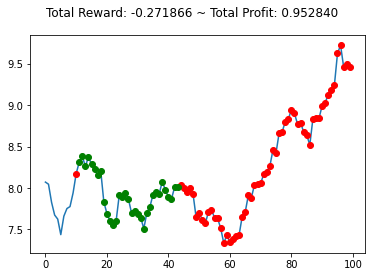

In [ ]:
env2.render_all()

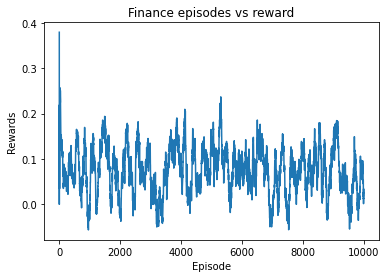

In [ ]:
plt.title("Finance episodes vs reward")
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.plot(avg_r100)
plt.show()

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

episode = 10
avg_r100= []
avg_r10 = []
reward_per_episode = []
for i in range(episode):
    prev_state = env.reset()
    done = False
    cumulative_reward = 0
    while not done:
        print(prev_state)
        action = agent.stepWithoutNoise(prev_state.flatten())
        obs, reward, done, _ = env2.step(action)# prev_state, action, reward, next_state, done
        agent.replay_buffer.add(prev_state, action, reward, obs, int(done))
        prev_state=obs
        cumulative_reward += reward
        #agent.learnPolicy()
    if i%200==0:
      print("episode: ", i)
    avrRew100 = np.mean(reward_per_episode[-100:])
    avrRew10 = np.mean(reward_per_episode[-10:])
    avg_r100.append(avrRew100)
    avg_r10.append(avrRew10)
    env.render()

    reward_per_episode.append(cumulative_reward)

In [ ]:
env2.render_all()